# Import

In [2]:
!pip install captum
import captum
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# # import torchvision module to handle image manipulation
# import torchvision
# import torchvision.transforms as transforms

# # calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

# torch.set_printoptions(linewidth=120)
# torch.set_grad_enabled(True)     # On by default, leave it here for clarity

     |████████████████████████████████| 1.4 MB 4.2 MB/s 


In [3]:
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

# Praca Domowa 2

Indywidualnie, zaimplementować model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji w `torch` i przetestować go na **wybranym zbiorze danych**. Powstały raport w formatach `.ipynb` oraz `.html` powinien zawierać wnioski z przeprowadzonej analizy.
1. 1 punkt uzyskuje się za pracę z zbiorem danych [CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)  (60k [take a subset: 1/3-1/2], 10 classes, 32x32 images)
2. 2 punkty uzyskuje się za pracę z zbiorem danych [OxfordIIITPet](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html)  (7.4k, 37 classes, varied sizes of images)
3. 3 punkty uzyskuje się za pracę z zbiorem danych [StanfordCars](https://pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html) (17k [if too large, take a subset], 196 classes, 360×240 images)

- do 2 punktów uzyskuje się za wytrenowanie skutecznego modelu ResNet (porównać dwie wielkości, np. 18 i 34, na zbiorze treningowym i testowym)
- 1 punkt uzyskuje się za zaprezentowanie zwalczania zjawiska przeuczenia wykorzystując Dropout (lub inny sposób regularyzacji)
- 1 punkt uzyskuje się za zwizualizowanie macierzy konfuzji ORAZ pokazanie ozasadnionych/ciekawych przykłady obrazów, na których model się mylił 
- 1 punkt uzyskuje się za zwizualizowanie wektora reprezentacji obrazów w podziale na klasy (kolor), wykorzystując PCA/TSNE (lub inny algorytm redukcji wymiaru)
- do 2 punktów uzyskuje sie za jakość raportu (opisu, wizualizacji, kodu), a w szczególności *agregację wyników* w postaci tabel lub/i wykresów.

**Uwaga!** (1) Zabronione jest importowanie modeli z bibliotek; można korzystać z repozytoriów takich jak https://github.com/kuangliu/pytorch-cifar. (2) Warto zacząć od uczenia sieci na podzbiorze, np. 10%, danych treningowych (i ewaluowania na podzbiorze danych testowych) dla zaoszczędzenia czasu. 

Praca domowa jest na 8 punktów (można uzyskać max 10 punktów).

Deadline: 30 marca 23:59. Na zajęciach 31 marca 5 wybranch osób krótko zaprezentuje swoje wyniki.

Pracę zgłaszamy poprzez PR o tytule `[PD2] Imię Nazwisko` do folderu `homeworks/pd2/imię_nazwisko`.

# Wizualizacja wektora reprezentacji obrazów

Przykład: https://medium.com/@pslinge144/representation-learning-cifar-10-23b0d9833c40


# Wczytanie danych CIFAR10

In [4]:
import torchvision
import torchvision.transforms as transforms

In [84]:
train_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10train',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

Files already downloaded and verified


In [85]:
test_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10test',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

Files already downloaded and verified


In [7]:
import random
random.seed(1)

In [66]:
small1 = random.sample(list(range(len(train_set))), round(len(train_set)/10))
small2 = random.sample(list(range(len(test_set))), round(len(test_set)/10))

In [67]:
train_set_subset = torch.utils.data.Subset(train_set, small1)
test_set_subset = torch.utils.data.Subset(test_set, small2)


# Używam resnet z https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# RunBuilder

In [29]:
from collections  import OrderedDict
params = OrderedDict(
    lr = [.01, .001],
    batch_size = [100, 500],
    shuffle = [True, False]
)
epochs = 3

In [30]:
# import modules to build RunBuilder and RunManager helper classes
from collections import namedtuple
from itertools import product

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.tb = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images.to(DEVICE))

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images.to(DEVICE))

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)
    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)

    # Record epoch loss and accuracy to TensorBoard 
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
    self.tb.add_scalar('Accuracy_test', accuracy_test, self.epoch_count)

    # Record params to TensorBoard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
  # save end results of all runs into csv, json for further analysis
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [31]:
def Run_experiments(net, train_set,test_set, params, epochs):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params):

      # if params changes, following line of code should reflect the changes too
      network = net.to(DEVICE)
      loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
      loader_test = torch.utils.data.DataLoader(test_set, batch_size = run.batch_size)
      optimizer = optim.Adam(network.parameters(), lr=run.lr)

      m.begin_run(run, network, loader,loader_test)
      for epoch in range(epochs):
        
        m.begin_epoch()
        for batch in loader:
          
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          loss = F.cross_entropy(preds, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          m.track_loss(loss)
          m.track_num_correct(preds, labels)
        
        for batch in loader_test:
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          m.track_num_correct_test(preds, labels)

        m.end_epoch()
      m.end_run()
      

  return m

# Run experiments

In [27]:
len(train_set_subset)

5000

In [28]:
m_rn18 = Run_experiments(ResNet18(),train_set_subset,test_set_subset, params, epochs)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.439105,0.1910,0.237,16.793387,17.689543,0.010,100,True
1,1,2,1.965282,0.2696,0.306,16.690804,37.366865,0.010,100,True
2,1,3,1.817569,0.3184,0.342,16.723892,56.794817,0.010,100,True
3,2,1,1.949588,0.2728,0.316,16.711907,17.557559,0.010,100,False
4,2,2,1.698990,0.3712,0.371,16.603512,36.893233,0.010,100,False
5,2,3,1.589437,0.4060,0.402,16.699006,56.254790,0.010,100,False
6,3,1,1.545442,0.4338,0.452,14.371909,17.236421,0.010,500,True
7,3,2,1.412423,0.4792,0.443,14.240250,34.237142,0.010,500,True
8,3,3,1.339947,0.5022,0.460,14.272580,51.200348,0.010,500,True
9,4,1,1.407098,0.4828,0.456,14.263612,17.099117,0.010,500,False


In [32]:
m_rn34 = Run_experiments(ResNet34(),train_set_subset,test_set_subset, params, epochs)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.864940,0.1356,0.183,26.310163,27.667983,0.010,100,True
1,1,2,2.100039,0.2188,0.258,26.541264,59.326276,0.010,100,True
2,1,3,1.949683,0.2788,0.273,26.465368,90.924792,0.010,100,True
3,2,1,2.084664,0.2282,0.279,26.512916,27.889878,0.010,100,False
4,2,2,1.894516,0.2858,0.296,26.458372,59.425727,0.010,100,False
5,2,3,1.763660,0.3400,0.354,26.426189,90.952377,0.010,100,False
6,3,1,1.728363,0.3564,0.380,22.952266,27.299370,0.010,500,True
7,3,2,1.599183,0.4180,0.403,23.364302,55.579245,0.010,500,True
8,3,3,1.532044,0.4374,0.425,22.895730,83.445572,0.010,500,True
9,4,1,1.598252,0.4196,0.393,22.951546,27.308798,0.010,500,False


# Wnioski
Resnet34 na początku eksperymentu ma podobne wyniki jak Resnet18, ale wraz ze spadkiem `learnin rate`, Resnet18 osiąga lepsze wyniki. Biorą pod uwagę lepsze `accuracy` i mniejszy czas trwania epoki wybrałabym model ResNet18. Nawet jeżeli na ResNet18 osiągamy `accuracy` prawię 0.90 to warto zauważyć, że na zbiorze testowy `accuracy` osiągało tylko ok 0.52. Rozważmy więc model ResNet18 z `learning_rate` 0.001, `batch_size` 500 i `shuffle` True (wtedy osiągamy najlepsze `accuracy` na testowym i prawię najwyższe `accuracy` na treningowym.

In [33]:
params2 = OrderedDict(
    lr = [.001],
    batch_size = [500],
    shuffle = [True]
)
epochs2 = 10

In [38]:
m_rn18_v2 = Run_experiments(ResNet18(),train_set,test_set, params2, epochs2)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.511631,0.44560,0.5747,143.637794,146.631742,0.001,500,True
1,1,2,0.989592,0.64646,0.6813,145.373810,294.776569,0.001,500,True
2,1,3,0.747834,0.73586,0.7401,144.526123,442.050682,0.001,500,True
3,1,4,0.581146,0.79784,0.7820,144.142714,588.973007,0.001,500,True
4,1,5,0.465841,0.83648,0.7964,143.590918,735.384028,0.001,500,True
5,1,6,0.375569,0.87050,0.8008,144.929761,883.075155,0.001,500,True
6,1,7,0.307863,0.89240,0.8033,143.512032,1029.677931,0.001,500,True
7,1,8,0.245366,0.91372,0.8040,141.979642,1174.445146,0.001,500,True
8,1,9,0.186717,0.93526,0.8107,142.098616,1319.283160,0.001,500,True
9,1,10,0.141836,0.94990,0.8186,142.335227,1464.384902,0.001,500,True


# Dropout + wykres

In [39]:
import matplotlib.pyplot as plt

In [43]:
class ResNet_Dropout(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet_Dropout, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.9)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.dropout(out)
        out = self.layer2(out)
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [44]:
def ResNet18_dropout():
    return ResNet_Dropout(BasicBlock, [2, 2, 2, 2])

In [41]:
def Run_experiments_return_model(net, train_set,test_set, params, epochs):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params):

      # if params changes, following line of code should reflect the changes too
      network = net.to(DEVICE)
      loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
      loader_test = torch.utils.data.DataLoader(test_set, batch_size = run.batch_size)
      optimizer = optim.Adam(network.parameters(), lr=run.lr)

      m.begin_run(run, network, loader,loader_test)
      for epoch in range(epochs):
        
        m.begin_epoch()
        for batch in loader:
          
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          loss = F.cross_entropy(preds, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          m.track_loss(loss)
          m.track_num_correct(preds, labels)
        
        for batch in loader_test:
          images = batch[0].to(DEVICE)
          labels = batch[1].to(DEVICE)
          preds = network(images)
          m.track_num_correct_test(preds, labels)

        m.end_epoch()
      m.end_run()
      

  return network

In [45]:
m_rn18_dropout = Run_experiments(ResNet18_dropout(),train_set,test_set, params2, epochs2)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.978188,0.24716,0.3060,142.770967,145.775212,0.001,500,True
1,1,2,1.646403,0.37470,0.4331,144.870731,293.383321,0.001,500,True
2,1,3,1.398341,0.47794,0.5199,145.372034,441.438634,0.001,500,True
3,1,4,1.235205,0.54780,0.5699,143.790651,588.378754,0.001,500,True
4,1,5,1.120121,0.59180,0.6055,142.786205,733.901996,0.001,500,True
5,1,6,1.044983,0.62166,0.6329,144.628148,881.232434,0.001,500,True
6,1,7,0.989724,0.64360,0.6434,143.062856,1027.026138,0.001,500,True
7,1,8,0.927544,0.66966,0.6589,143.912010,1173.618435,0.001,500,True
8,1,9,0.884266,0.68604,0.6686,145.949325,1322.249445,0.001,500,True
9,1,10,0.849214,0.69930,0.6837,145.136772,1470.066141,0.001,500,True


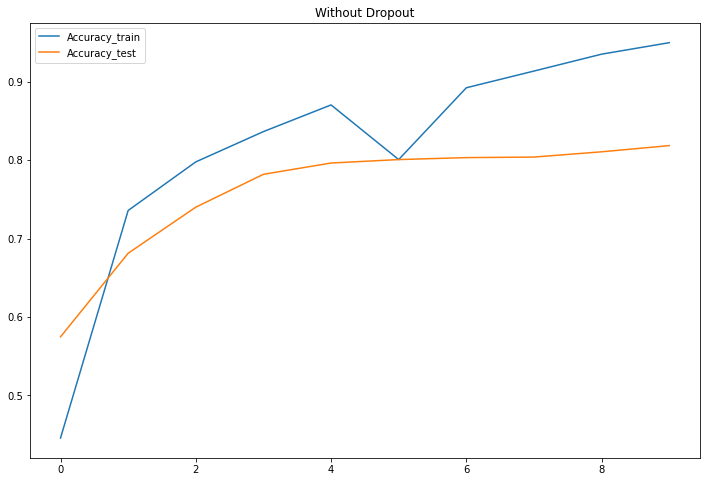

In [247]:
errors_train = [0.44560,0.73586 ,0.79784,0.83648,0.87050,0.8008,0.89240,0.91372,0.93526,0.94990]
errors_test = [0.5747,0.6813,0.7401,0.7820,0.7964,0.8008,0.8033,0.8040 ,0.8107,0.8186]
plt.figure(figsize=(12, 8))
plt.plot(range(10), errors_train)
plt.plot(range(10), errors_test)
plt.title('Without Dropout')
plt.legend(['Accuracy_train', 'Accuracy_test'])
plt.show()

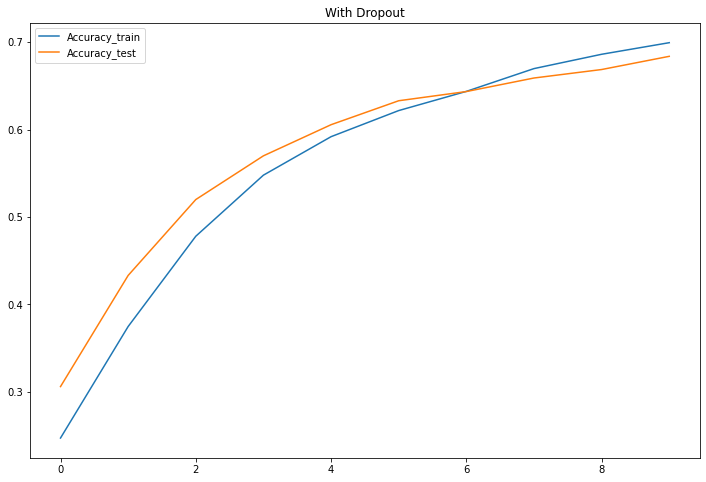

In [248]:
errors_train = [0.24716,0.37470,0.47794,0.54780,0.59180,0.62166, 0.64360,0.66966,0.68604, 0.69930]
errors_test = [0.3060,0.4331,0.5199,0.5699,0.6055,0.6329, 0.6434,0.6589,0.6686,0.6837 ]
plt.figure(figsize=(12, 8))
plt.plot(range(10), errors_train)
plt.plot(range(10), errors_test)
plt.title('With Dropout')
plt.legend(['Accuracy_train', 'Accuracy_test'])
plt.show()

Bez dropout:
* train: 0.94990
* test :0.8186

Z dropout:
* train: 0.69930
* test : 0.6837

Sieć z użyciem dropout po 10 epokach ma mniejsze `accuracy` niż bez dropout, ale łatwo zauważyć, że z użyciem dropout `accuracy` na zbiorze testowym i treningowym są bardziej zbliżone.

# Macierz konfuzji

In [86]:
m_rn18_v = Run_experiments_return_model(ResNet18(),train_set,test_set, params2, 6)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.461249,0.46696,0.5934,141.601823,144.539509,0.001,500,True
1,1,2,0.941618,0.66236,0.7073,142.801593,290.052830,0.001,500,True
2,1,3,0.703751,0.75122,0.7638,145.242967,438.073693,0.001,500,True
3,1,4,0.542880,0.81036,0.7870,142.018484,583.151312,0.001,500,True
4,1,5,0.428373,0.85038,0.7907,141.664117,727.653371,0.001,500,True
5,1,6,0.356413,0.87724,0.7908,142.520706,872.957105,0.001,500,True


In [87]:
dataloader_train = torch.utils.data.DataLoader(test_set)

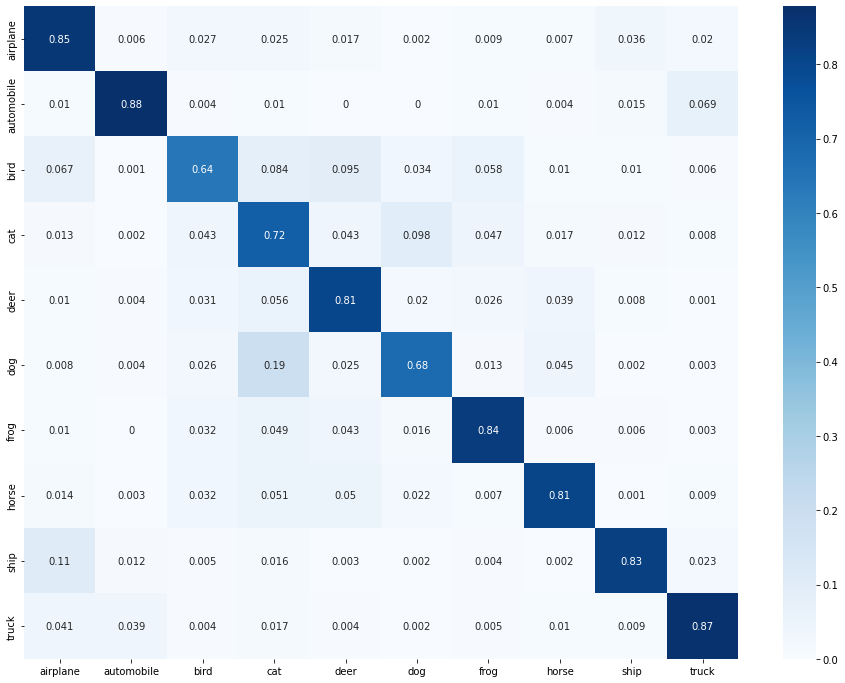

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
dataloader_train = torch.utils.data.DataLoader(train_set, batch_size = 500)
dataloader_test = torch.utils.data.DataLoader(test_set , batch_size = 500)

y_pred = []
y_true = []

# iterate over test data
for batch in dataloader_test:
        inputs = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        output = m_rn18_v(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

Z macierzy możemy odczytać, że model najczęściej "myli" kota z psem.
* pies - 5,
* kot  - 3,

In [136]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [132]:
mistake = []
for i in range (len(y_pred)):
  if y_pred[i] == 3 and y_true[i] == 5:
    mistake.append(i)

## Przyjrzyjmy się pomyłkom: pred - kot, true - pies
Wśród pomyłek pojawiają się zazwyczaj małe psy. Czesto więc w takich przypadkach człowiek jest w stanie poprawnie zaklasyfikować zwierze.

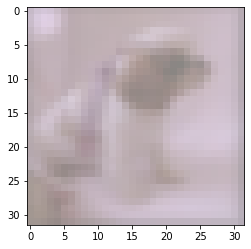

In [212]:
imshow(torchvision.utils.make_grid(test_set[mistake[3]][0]))

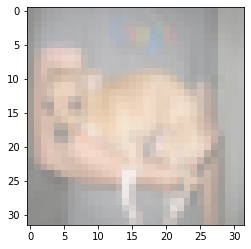

In [145]:
imshow(torchvision.utils.make_grid(test_set[mistake[8]][0]))

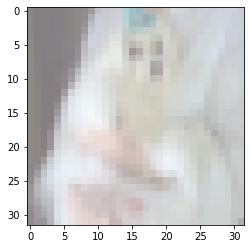

In [180]:
imshow(torchvision.utils.make_grid(test_set[mistake[41]][0]))

Czasem zdarzają się obrazy, które mogą byc łudzące dla ludzkiego oka. Dla mnie np ten piec wygląda jak kot przez jego poze i ogon.

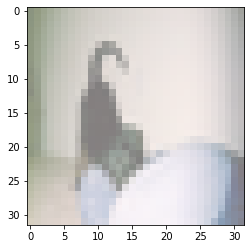

In [152]:
imshow(torchvision.utils.make_grid(test_set[mistake[15]][0]))

Wśród błędnie zaklasyfikowanych obrazów pojawiły się również takie, o których nie mogłabym się zastanawiać czy wogóle przypominają zwierzę.

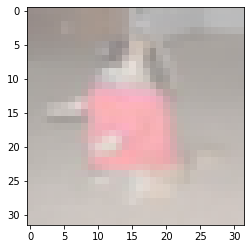

In [185]:
imshow(torchvision.utils.make_grid(test_set[mistake[46]][0]))

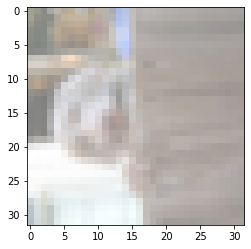

In [201]:
imshow(torchvision.utils.make_grid(test_set[mistake[63]][0]))